In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import KMeans
from sklearn.model_selection import (
    train_test_split,
    KFold,
    cross_val_score,
)
from imblearn.over_sampling import SMOTE
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (
    confusion_matrix,
    ConfusionMatrixDisplay,
    classification_report,
    accuracy_score,
    roc_curve,
)
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier

In [2]:
# Numpy deprecation issue
np.int = np.int32
np.float = np.float64
np.bool = np.bool_

In [3]:
df = pd.read_excel("./dataset.xlsx")

# Initial Observations and Data Cleanup


In [4]:
df.columns = [
    "satisfaction_level",
    "last_evaluation",
    "number_project",
    "average_montly_hours",
    "time_spend_company",
    "work_accident",
    "left",
    "promotion_last_5years",
    "department",  # "sales"
    "salary",
]
df.columns

Index(['satisfaction_level', 'last_evaluation', 'number_project',
       'average_montly_hours', 'time_spend_company', 'work_accident', 'left',
       'promotion_last_5years', 'department', 'salary'],
      dtype='object')

- Make column name casing consistent
- `department` column was mislabeled as `sales`


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14999 entries, 0 to 14998
Data columns (total 10 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   satisfaction_level     14999 non-null  float64
 1   last_evaluation        14999 non-null  float64
 2   number_project         14999 non-null  int64  
 3   average_montly_hours   14999 non-null  int64  
 4   time_spend_company     14999 non-null  int64  
 5   work_accident          14999 non-null  int64  
 6   left                   14999 non-null  int64  
 7   promotion_last_5years  14999 non-null  int64  
 8   department             14999 non-null  object 
 9   salary                 14999 non-null  object 
dtypes: float64(2), int64(6), object(2)
memory usage: 1.1+ MB


In [6]:
df.isna().sum()

satisfaction_level       0
last_evaluation          0
number_project           0
average_montly_hours     0
time_spend_company       0
work_accident            0
left                     0
promotion_last_5years    0
department               0
salary                   0
dtype: int64

- No null data to handle
- `department` and `salary` are the only non-numerical columns and will need to be encoded


In [7]:
print(df["department"].value_counts())
print(df["salary"].value_counts())

department
sales          4140
technical      2720
support        2229
IT             1227
product_mng     902
marketing       858
RandD           787
accounting      767
hr              739
management      630
Name: count, dtype: int64
salary
low       7316
medium    6446
high      1237
Name: count, dtype: int64


# EDA


In [8]:
df.columns

Index(['satisfaction_level', 'last_evaluation', 'number_project',
       'average_montly_hours', 'time_spend_company', 'work_accident', 'left',
       'promotion_last_5years', 'department', 'salary'],
      dtype='object')

In [9]:
df["salary"].value_counts()

salary
low       7316
medium    6446
high      1237
Name: count, dtype: int64

- Low and Medium salary ranges make up the bulk of employee datapoints
- We may need to account for this to properly train a model if there are not enough High range datapoints


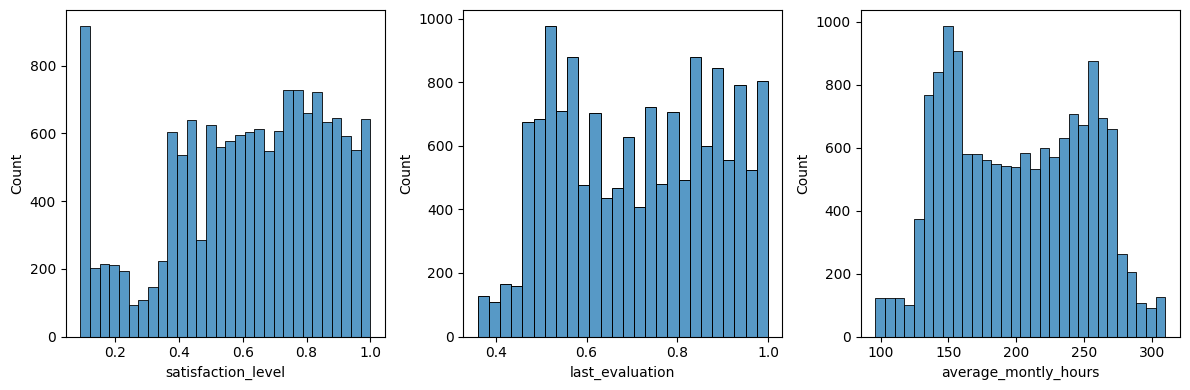

In [10]:
fig, axes = plt.subplots(ncols=3, nrows=1, figsize=(12, 4))
sns.histplot(df["satisfaction_level"], ax=axes[0])
sns.histplot(df["last_evaluation"], ax=axes[1])
sns.histplot(df["average_montly_hours"], ax=axes[2])
plt.tight_layout(h_pad=2, w_pad=1)

- `satisfaction_level` is negatively skewed and needs further investigation to help identify factors relating to low employee satisfaction
- `last_evaluation` is slightly positively skewed. Having more better performing employees is a good thing.
- `average_monthly_hours` has a fairly normal distribution, with the bulk of employees ranging from 140 - 260 hours per month (7-11 hours per working day). Further investigation should be conducted to see the relationship, if any, between `average_monthly_hours` and `satisfaction_level`


### Satisfaction Level


([0, 1, 2, 3, 4, 5, 6, 7, 8, 9],
 [Text(0, 0, 'IT'),
  Text(1, 0, 'RandD'),
  Text(2, 0, 'accounting'),
  Text(3, 0, 'hr'),
  Text(4, 0, 'management'),
  Text(5, 0, 'marketing'),
  Text(6, 0, 'product_mng'),
  Text(7, 0, 'sales'),
  Text(8, 0, 'support'),
  Text(9, 0, 'technical')])

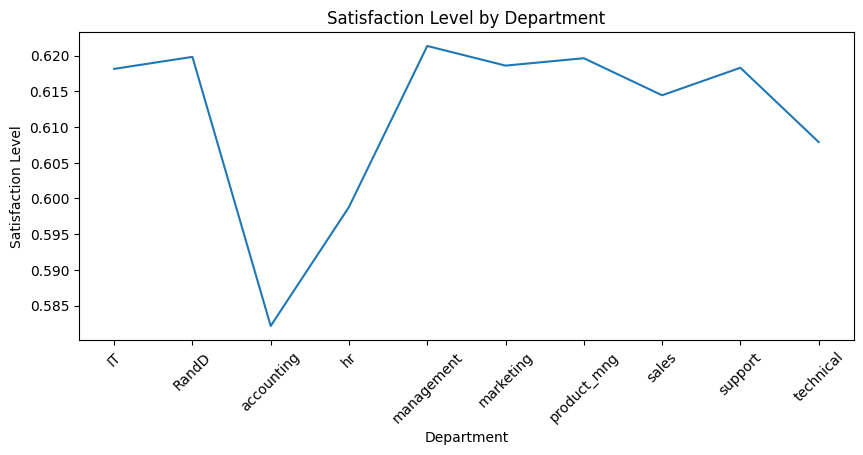

In [11]:
plt.figure(figsize=(10, 4))
sns.lineplot(df.groupby("department")["satisfaction_level"].mean())
plt.title("Satisfaction Level by Department")
plt.xlabel("Department")
plt.ylabel("Satisfaction Level")
plt.xticks(rotation=45)

Accounting has, by far, the lowest satisfaction level among departments, followed by Technical


([0, 1, 2, 3, 4, 5, 6, 7, 8, 9],
 [Text(0, 0, 'IT'),
  Text(1, 0, 'RandD'),
  Text(2, 0, 'accounting'),
  Text(3, 0, 'hr'),
  Text(4, 0, 'management'),
  Text(5, 0, 'marketing'),
  Text(6, 0, 'product_mng'),
  Text(7, 0, 'sales'),
  Text(8, 0, 'support'),
  Text(9, 0, 'technical')])

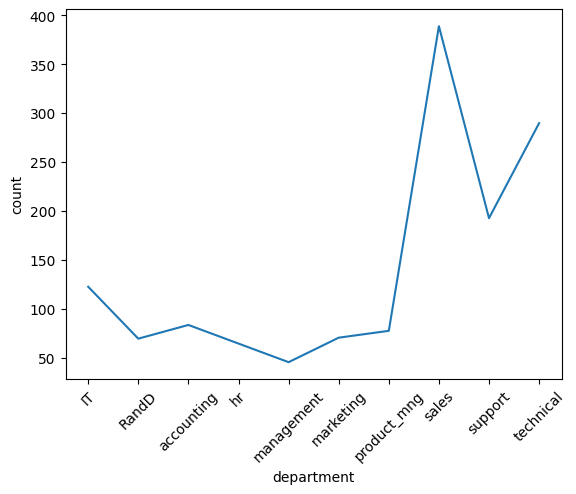

In [98]:
low_satisfaction = df[df['satisfaction_level'] < 0.2]

sns.lineplot(low_satisfaction.groupby('department')['department'].value_counts())
plt.xticks(rotation=45)

Text(0, 0.5, 'Percent Salary Range')

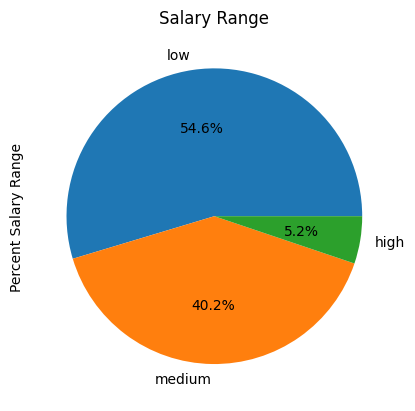

In [99]:
low_satisfaction["salary"].value_counts(normalize=True).plot.pie(autopct="%1.1f%%")
plt.title("Salary Range")
plt.ylabel("Percent Salary Range")

In [102]:
print(f"// avg monthly hours (whole dataset): {df['average_montly_hours'].mean()}")
print(
    f"// avg monthly hours (low satisfaction): {low_satisfaction['average_montly_hours'].mean()}"
)

print(f"// num projects (whole dataset): {df['number_project'].mean()}")
print(f"// num projects (low satisfaction): {low_satisfaction['number_project'].mean()}")

print(
    f"// promotion in last 5 years (whole dataset): {df['promotion_last_5years'].mean()}"
)
print(
    f"// promotion in last 5 years (low satisfaction): {low_satisfaction['promotion_last_5years'].mean()}"
)

print(
    f"// last evaluation (whole dataset): {df['last_evaluation'].mean()}"
)
print(
    f"// last evaluation (low satisfaction): {low_satisfaction['last_evaluation'].mean()}"
)

// avg monthly hours (whole dataset): 201.0503366891126
// avg monthly hours (low satisfaction): 250.17601135557132
// num projects (whole dataset): 3.80305353690246
// num projects (low satisfaction): 5.584811923349894
// promotion in last 5 years (whole dataset): 0.021268084538969265
// promotion in last 5 years (low satisfaction): 0.0099361249112846
// last evaluation (whole dataset): 0.7161017401160078
// last evaluation (low satisfaction): 0.8140028388928316


Despite having similar salary range makeup to the dataset on the whole, employees reporting satisfaction levels below 0.2 work:
- 40 more hours a month on average
- Work on more projects
- Received promotions at a much lower rate, despite receiving higher scores on their last evaluation

### Correlation


<Axes: >

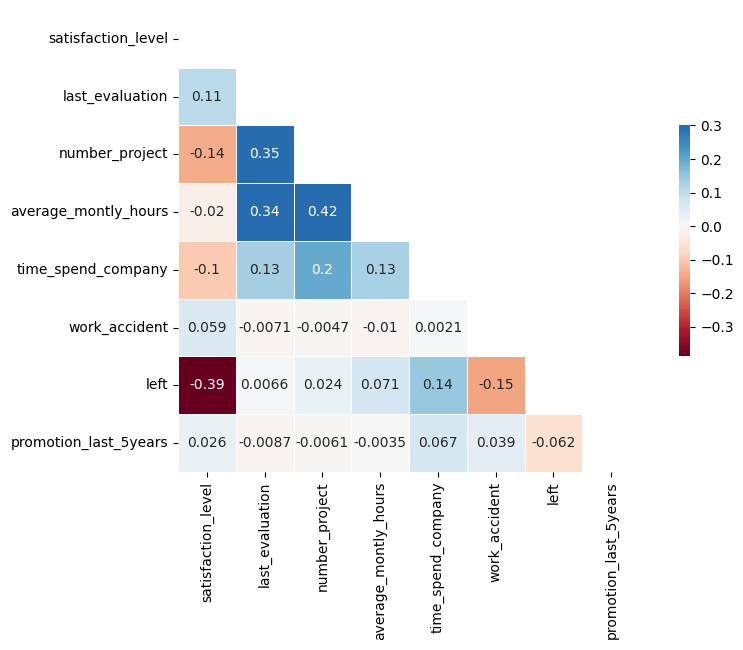

In [13]:
corr = df.corr(numeric_only=True)
# Generate a mask for the upper triangle
mask = np.triu(np.ones_like(corr, dtype=bool))

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(10, 6))

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(
    corr,
    mask=mask,
    cmap="RdBu",
    vmax=0.3,
    center=0,
    square=True,
    linewidths=0.5,
    cbar_kws={"shrink": 0.5},
    annot=True,
)

- There is a relatively strong positive correlation between employees' last evaluation and the average monthly hours and number of projects, suggesting that employees who worked more hours and on more projects scored higher on their last evaluation
- Unsurprisingly, there is a relatively strong negative correlation between satisfaction level and the employee leaving the company
- There is a moderately strong positive correlation between last evaluation and satisfaction level, suggesting that employees who were evaluated more positively also have a higher level of satisfaction
- There is a moderately strong negative correclation between time spent at the company and number of projects worked on and employee satisfaction


### Left/Stayed


[Text(0, 0, 'Stayed'), Text(0, 1, 'Left')]

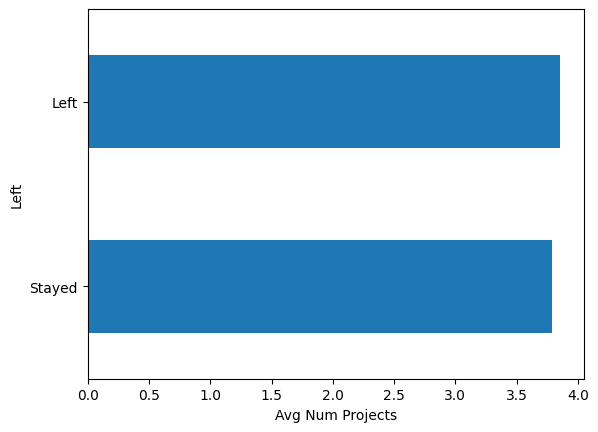

In [14]:
fig = df.groupby("left")["number_project"].mean().plot(kind="barh")
fig.set_xlabel("Avg Num Projects")
fig.set_ylabel("Left")
fig.set_yticklabels(["Stayed", "Left"])

Employees who remained at the company worked on slightly fewer projects on average than those who left


# Clustering & Further EDA


In [15]:
KM = KMeans(n_clusters=3, random_state=1, n_init=10)

df_left = pd.DataFrame(df[df["left"] == 1])
colors = ["#9004FF", "#FEBA0C", "#00B3A8"]  # purple(0), yellow(1), green(2)

df_left["clusters"] = KM.fit_predict(df_left[["satisfaction_level", "last_evaluation"]])
df_left["colors"] = df_left["clusters"].map({0: colors[0], 1: colors[1], 2: colors[2]})

Text(0.5, 1.0, 'KMeans Clustering')

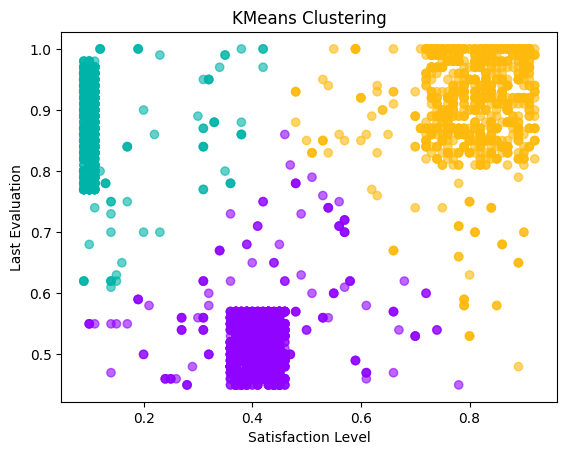

In [16]:
plt.scatter(
    x=df_left["satisfaction_level"],
    y=df_left["last_evaluation"],
    c=df_left["colors"],
    alpha=0.6,
)
plt.xlabel("Satisfaction Level")
plt.ylabel("Last Evaluation")
plt.title("KMeans Clustering")

Those who left fall moderately well into 3 cluters. Clustering is dense, though there are some outliers that make clustering less descrete. Outlier treatment could be considered to clean this up further if no well-performing model can be found.

**Poor Fit for Company (purple)**
</br> This cluster can be identified as having relatively low satisfaction level for the company but also relatively low score from the last evaluation. These employees seem to simply be a poor fit for the company: neither they nor the company are satisfied. While better retention strategies could be identified for this group, efforts might be better spent on the other two clusters where employee performance is scored higher.

**Low Satisfaction, High Evaluation (green)**
</br> This cluster of former employees received a relatively high score on their last evaluation but they are very dissatisfied with the company. This cluster needs further investigation. The company has found this group to be a valuable subset of employees but the employees are not happy. If pain points can be identified and improved, this could be an area for better retention of high-performing employees.

**High Satisfaction, High Evaluation (yellow)**
</br> This cluster is characterized by employees who were both largely satisfied with the company and also higher-performing. This is the area where efforts are likely best spent, as these employees are relatively happy with the company and perform well. Are there small changes and improvements that can be made (higher salaries, fewer projects, an unpopular department manager) to keep a higher percentage of these employees with the company?


## EDA


In [17]:
sub_low_sat_high_eval = df_left[df_left["clusters"] == 2]
sub_high_sat_high_eval = df_left[df_left["clusters"] == 1]
salary_cats_order = ["low", "medium", "high"]

Text(0, 0.5, 'Department')

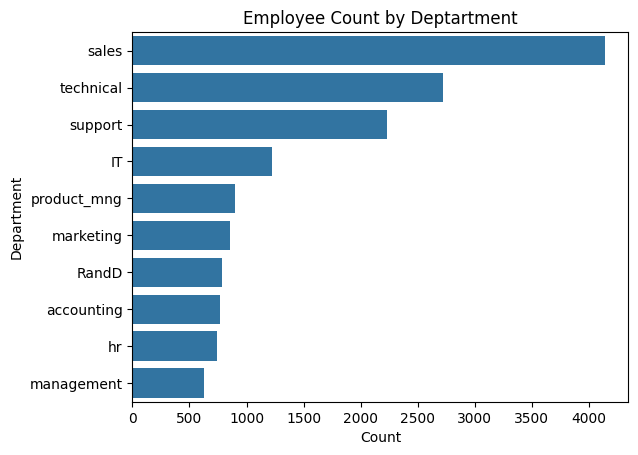

In [18]:
sns.countplot(
    df,
    y="department",
    order=df["department"].value_counts().index,
)
plt.title("Employee Count by Deptartment")
plt.xlabel("Count")
plt.ylabel("Department")

([0, 1, 2, 3, 4, 5, 6, 7, 8, 9],
 [Text(0, 0, 'IT'),
  Text(1, 0, 'RandD'),
  Text(2, 0, 'accounting'),
  Text(3, 0, 'hr'),
  Text(4, 0, 'management'),
  Text(5, 0, 'marketing'),
  Text(6, 0, 'product_mng'),
  Text(7, 0, 'sales'),
  Text(8, 0, 'support'),
  Text(9, 0, 'technical')])

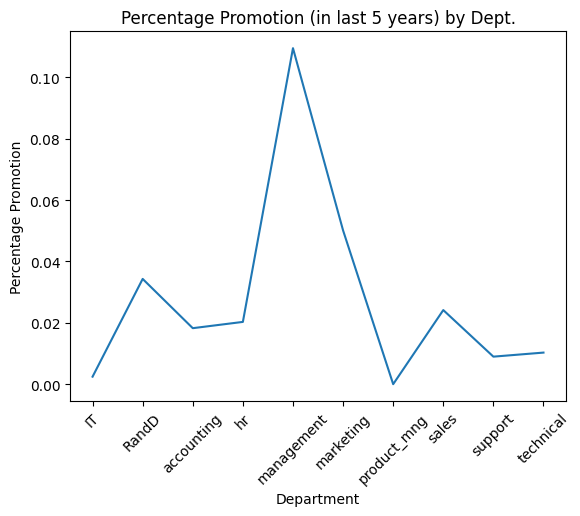

In [19]:
sns.lineplot(
    df.groupby("department")["promotion_last_5years"].mean(),
)
plt.title("Percentage Promotion (in last 5 years) by Dept.")
plt.xlabel("Department")
plt.ylabel("Percentage Promotion")
plt.xticks(rotation=45)

Management has the highest percentage of promotions in the past 5 years. Support and Technical departments have the 2nd and 3rd highest employee count amongst departments but have the smallest percentage of promotions in the past 5 years.


Text(0, 0.5, 'Percent Salary Range')

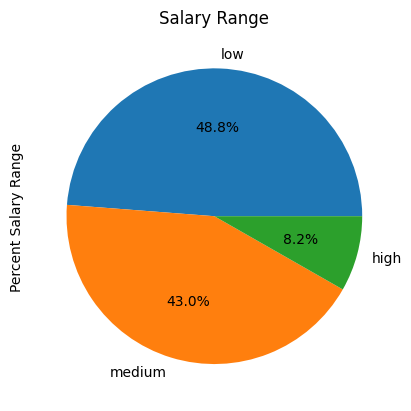

In [20]:
df["salary"].value_counts(normalize=True).plot.pie(autopct="%1.1f%%")
plt.title("Salary Range")
plt.ylabel("Percent Salary Range")

(array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9]),
 [Text(0, 0, 'IT'),
  Text(1, 0, 'RandD'),
  Text(2, 0, 'accounting'),
  Text(3, 0, 'hr'),
  Text(4, 0, 'management'),
  Text(5, 0, 'marketing'),
  Text(6, 0, 'product_mng'),
  Text(7, 0, 'sales'),
  Text(8, 0, 'support'),
  Text(9, 0, 'technical')])

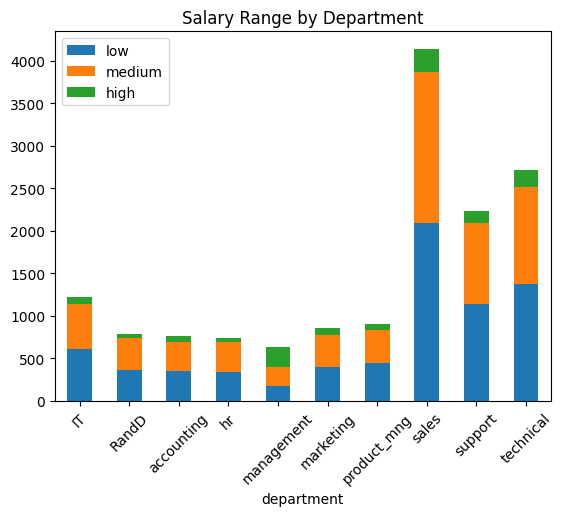

In [21]:
grouped = df.groupby("department")["salary"].value_counts().unstack()
grouped.columns = pd.CategoricalIndex(
    grouped.columns.values, ordered=True, categories=salary_cats_order
)
grouped = grouped.sort_index(axis=1)
grouped.plot(kind="bar", stacked=True)
plt.title("Salary Range by Department")
plt.xticks(rotation=45)

Management has the highest proportion of high salaried employees by department


### Low Satisfaction, High Evaluation Cluster


In [22]:
pd.crosstab(
    sub_low_sat_high_eval["department"], sub_low_sat_high_eval["promotion_last_5years"]
)

promotion_last_5years,0,1
department,,
IT,87,0
RandD,37,0
accounting,60,0
hr,50,0
management,29,0
marketing,42,0
product_mng,41,0
sales,243,0
support,139,0


Of all departments in this cluster, Technical was the only department to have any promotions in the past 5 years. This could be an area for improvement, as this cluster has relatively high performing employees (scored greater than 0.75 on their last evaluation). Why are these employees not being promoted?


Text(0, 0.5, 'Percent Salary Range')

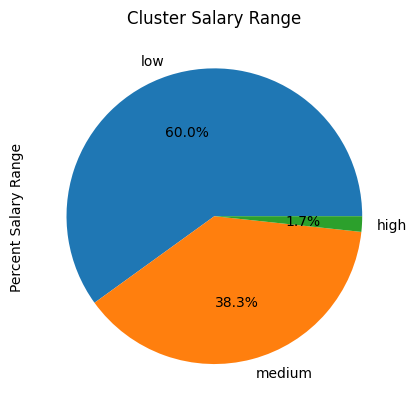

In [23]:
sub_low_sat_high_eval["salary"].value_counts(normalize=True).plot.pie(autopct="%1.1f%%")
plt.title("Cluster Salary Range")
plt.ylabel("Percent Salary Range")

This cluster also has a larger share of low salaried employees than the average, as well as a smaller share of medium and high salaried employees. This could be a contributing factor to low employee satisfaction as well.


### High Satisfaction, High Evaluation Cluster


In [24]:
pd.crosstab(
    sub_high_sat_high_eval["department"],
    sub_high_sat_high_eval["promotion_last_5years"],
)

promotion_last_5years,0,1
department,,
IT,69,0
RandD,35,0
accounting,44,0
hr,50,0
management,21,3
marketing,54,0
product_mng,69,0
sales,272,1
support,168,0


Text(0, 0.5, 'Percent Salary Range')

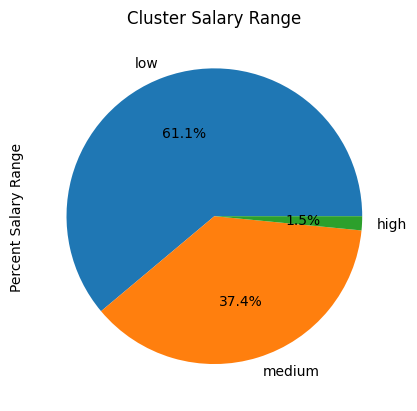

In [25]:
sub_high_sat_high_eval["salary"].value_counts(normalize=True).plot.pie(
    autopct="%1.1f%%"
)
plt.title("Cluster Salary Range")
plt.ylabel("Percent Salary Range")

Similarly in this cluster, promotion rates are low and medium and high salary ranges are low relatively to the dataset on the whole.


# Data Prep


In [26]:
df.dtypes

satisfaction_level       float64
last_evaluation          float64
number_project             int64
average_montly_hours       int64
time_spend_company         int64
work_accident              int64
left                       int64
promotion_last_5years      int64
department                object
salary                    object
dtype: object

In [27]:
print(df.salary.unique())
print(df.department.unique())

['low' 'medium' 'high']
['sales' 'accounting' 'hr' 'technical' 'support' 'management' 'IT'
 'product_mng' 'marketing' 'RandD']


In [28]:
# Encode salary (ordinal)
df_encoded = pd.DataFrame(df)
df_encoded["salary"] = df["salary"].map({"low": 1, "medium": 2, "high": 3})

# Encode department (standard)
df_encoded = pd.get_dummies(df_encoded, columns=["department"], dtype=int)

# Data Splitting


In [29]:
X = df_encoded.drop("left", axis=1)
y = df_encoded["left"]

In [30]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

In [31]:
X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y, test_size=0.2, random_state=123
)

## Resampling


In [32]:
smote_model = SMOTE()
X_resampled, y_resampled = smote_model.fit_resample(X_train, y_train)

# Train and Cross-Validate Models


## Logistic Regression


In [33]:
LR = LogisticRegression()
LR_model = LR.fit(X_train, y_train)

In [34]:
k_fold = KFold(n_splits=5)
results = cross_val_score(LR, X_train, y_train, cv=k_fold)
print(f"// Cross Validated Mean: {results.mean()}")

// Cross Validated Mean: 0.7948996109490064


In [35]:
y_test_hat_lr = LR_model.predict(X_test)
print(f"// Accuracy Score: {accuracy_score(y_test, y_test_hat_lr)}")

// Accuracy Score: 0.7913333333333333


This model performs moderately well


## Random Forest


In [36]:
RFC = RandomForestClassifier(n_estimators=1000, max_depth=6, random_state=10)
RFC_model = RFC.fit(X_train, y_train)

In [37]:
k_fold = KFold(n_splits=5)
results = cross_val_score(RFC, X_train, y_train, cv=k_fold)
print(f"// Cross Validated Mean: {results.mean()}")

// Cross Validated Mean: 0.9714979157982493


In [38]:
y_test_hat_rfc = RFC_model.predict(X_test)
print(f"// Accuracy Score: {accuracy_score(y_test, y_test_hat_rfc)}")

// Accuracy Score: 0.9723333333333334


This model appears to be performing very well. We should look to make sure this high performance isn't due to overfitting.


### Overfitting Check


In [39]:
train_scores = list()
test_scores = list()
values = list(range(1, 21))

for i in values:
  # define my model
  model = RandomForestClassifier(max_depth=i)
  model.fit(X_train, y_train)
  # run prediction for training
  y_hat_train = model.predict(X_train)
  train_accu = accuracy_score(y_train, y_hat_train) # actual vs predicted
  # run prediction for testing
  y_hat_test = model.predict(X_test)
  test_accu = accuracy_score(y_test, y_hat_test) # actual vs predicted

  # append the calculated values to our lists
  train_scores.append(train_accu)
  test_scores.append(test_accu)

  # print(f'depth: {i} \t| train: {train_accu:.2f} \t| test: {test_accu:.2f}')

plt.plot(values, train_scores, marker="D", label="Train")
plt.plot(values, test_scores, marker="D", label="Test")
plt.legend()
plt.xticks(values)

There are not obvious signs of overfitting. A performant max-depth appears to be between 6-8.


## Gradient Boosting


In [40]:
GB = GradientBoostingClassifier(n_estimators=500, max_depth=3)
GB_model = GB.fit(X_train, y_train)

In [41]:
k_fold = KFold(n_splits=5)
results = cross_val_score(GB, X_train, y_train, cv=k_fold)
print(f"// Cross Validated Mean: {results.mean()}")

// Cross Validated Mean: 0.980415242462137


In [42]:
y_test_hat_gb = GB_model.predict(X_test)
print(f"// Accuracy Score: {accuracy_score(y_test, y_test_hat_gb)}")

// Accuracy Score: 0.9823333333333333


This model also appears to be performing very well. We should look into overfitting.


### Overfitting Check


In [43]:
train_scores = list()
test_scores = list()
values = list(range(1, 21))

for i in values:
  # define my model
  model = GradientBoostingClassifier(max_depth=i)
  model.fit(X_train, y_train)
  # run prediction for training
  y_hat_train = model.predict(X_train)
  train_accu = accuracy_score(y_train, y_hat_train) # actual vs predicted
  # run prediction for testing
  y_hat_test = model.predict(X_test)
  test_accu = accuracy_score(y_test, y_hat_test) # actual vs predicted

  # append the calculated values to our lists
  train_scores.append(train_accu)
  test_scores.append(test_accu)

  # print(f'depth: {i} \t| train: {train_accu:.2f} \t| test: {test_accu:.2f}')

plt.plot(values, train_scores, marker="D", label="Train")
plt.plot(values, test_scores, marker="D", label="Test")
plt.legend()
plt.xticks(values)

This model appears to be performing very well, despite signs of overfitting at increased depths. Adjusting max depth to 3.


# The Best Model


## Logistic Regression


In [44]:
print(classification_report(y_test, y_test_hat_lr))

              precision    recall  f1-score   support

           0       0.82      0.93      0.87      2291
           1       0.60      0.35      0.44       709

    accuracy                           0.79      3000
   macro avg       0.71      0.64      0.66      3000
weighted avg       0.77      0.79      0.77      3000



The Logistic Regression model has a precision of 82% and an accuracy of 79% so we can say it performs moderately well at predicting employees who will leave the company.


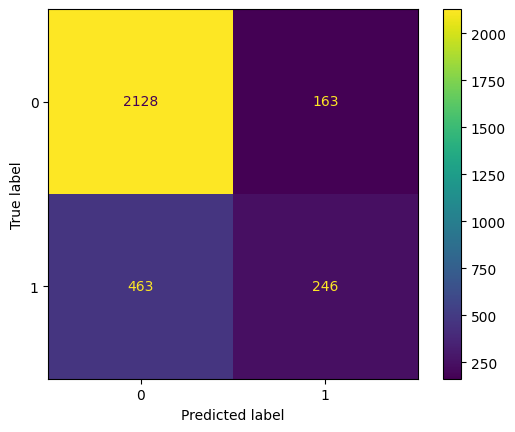

In [45]:
CM = confusion_matrix(y_test, y_test_hat_lr)
CM_plot = ConfusionMatrixDisplay(CM)
CM_plot.plot()

Text(0.5, 1.0, 'AUC/ROC Curve: Logistic Regression')

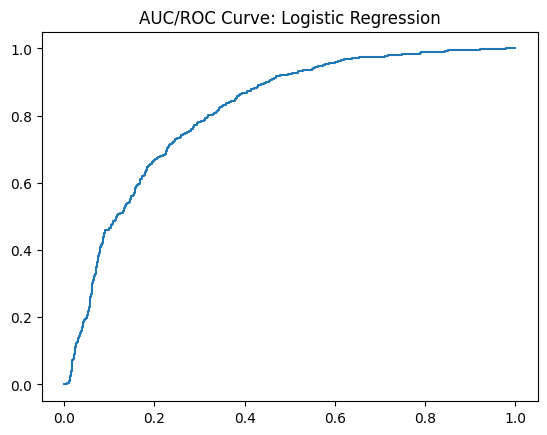

In [46]:
prob_score = LR_model.predict_proba(X_test)
prob_pos = prob_score[:, 1]

FPR, TPR, Threshold = roc_curve(y_test, prob_pos)
plt.plot(FPR, TPR)

plt.title("AUC/ROC Curve: Logistic Regression")

Similarly to other scoring and evaluation for this model, the AUC/ROC curve tells us that this model performs moderately well.


## Random Forest


In [47]:
print(classification_report(y_test, y_test_hat_rfc))

              precision    recall  f1-score   support

           0       0.97      0.99      0.98      2291
           1       0.98      0.90      0.94       709

    accuracy                           0.97      3000
   macro avg       0.97      0.95      0.96      3000
weighted avg       0.97      0.97      0.97      3000



This model's precision 97% and accuracy are very high at 97%. We can say this model's performance is excellent.


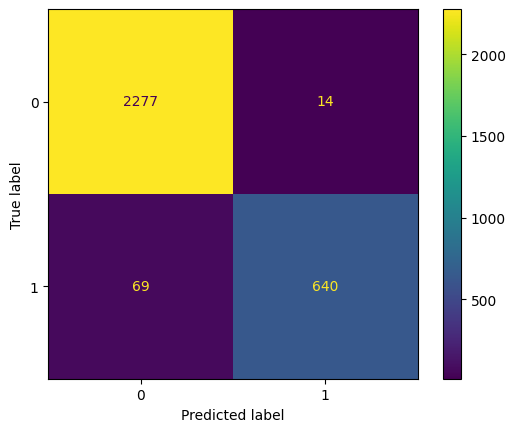

In [48]:
CM = confusion_matrix(y_test, y_test_hat_rfc)
CM_plot = ConfusionMatrixDisplay(CM)
CM_plot.plot()

Text(0.5, 1.0, 'AUC/ROC Curve: Random Forest')

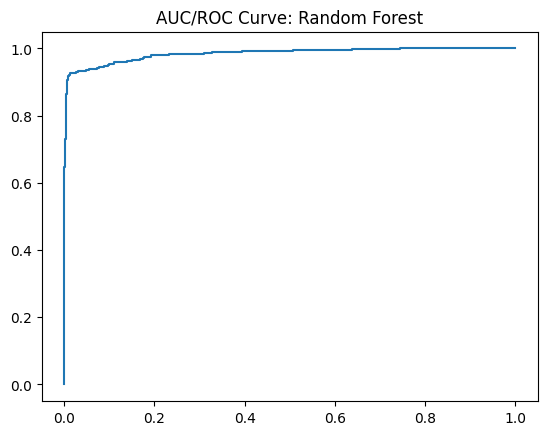

In [49]:
prob_score = RFC_model.predict_proba(X_test)
prob_pos = prob_score[:, 1]

FPR, TPR, Threshold = roc_curve(y_test, prob_pos)
plt.plot(FPR, TPR)
plt.title("AUC/ROC Curve: Random Forest")

## Gradient Boosting


In [50]:
print(classification_report(y_test, y_test_hat_gb))

              precision    recall  f1-score   support

           0       0.98      0.99      0.99      2291
           1       0.98      0.95      0.96       709

    accuracy                           0.98      3000
   macro avg       0.98      0.97      0.98      3000
weighted avg       0.98      0.98      0.98      3000



This model's precision 98% and accuracy are very high at 98%. We can say this model's performance is also excellent.


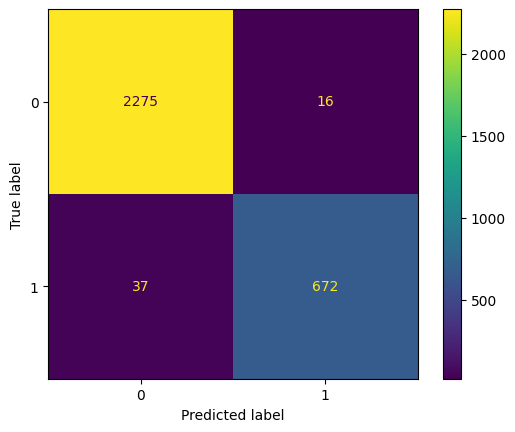

In [51]:
CM = confusion_matrix(y_test, y_test_hat_gb)
CM_plot = ConfusionMatrixDisplay(CM)
CM_plot.plot()

Text(0.5, 1.0, 'AUC/ROC Curve: Gradient Boosting')

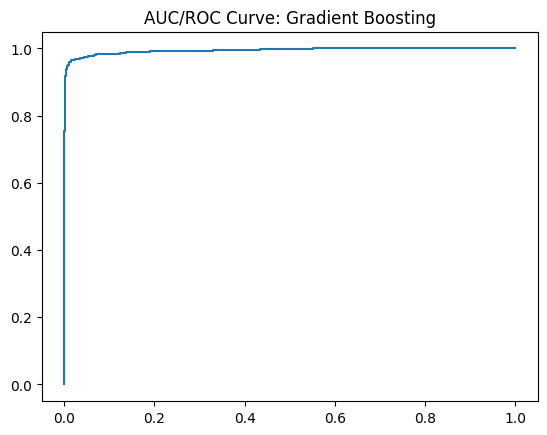

In [52]:
prob_score = GB_model.predict_proba(X_test)
prob_pos = prob_score[:, 1]

FPR, TPR, Threshold = roc_curve(y_test, prob_pos)
plt.plot(FPR, TPR)
plt.title("AUC/ROC Curve: Gradient Boosting")

## Evaluation


All models are moderately performant or better. With a high accuracy score, good precision and recall, and the best AUC/ROC curve, the `GradientBoostingClassifier` model is the best predictor. As the `RandomForrestClassifier` is nearly as good a predictor and is slightly more performant (from a memory and processing speed standpoint), we might consider using this model for large datasets.

If this were a real use case, perhaps further investigation would be completed over a longer period of time to make sure that this model really performs this well and is not a victim of overfitting.

In this case, we will move forward using the `GradientBoostingClassifier` model.


# Prediction and Retention Strategies


## Prediction


In [53]:
# Add turnover probability to dataframe
prob_turnover = GB_model.predict_proba(X.values)
df["turnover_probability"] = prob_turnover[:, 1]

In [54]:
# Group turnover probabilities into 4 zones
green = df["turnover_probability"] < 0.2
yellow = (df["turnover_probability"] >= 0.2) & (df["turnover_probability"] < 0.6)
orange = (df["turnover_probability"] >= 0.6) & (df["turnover_probability"] < 0.9)
red = df["turnover_probability"] >= 0.9
df["turnover_probability_zone"] = np.where(
    green, "green", np.where(yellow, "yellow", np.where(orange, "orange", "red"))
)

## Turnover Probability Zones


Text(0.5, 1.0, 'Turnover Probability Zones')

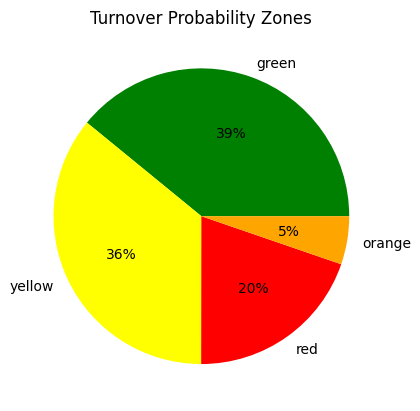

In [55]:
colors_in_order = df["turnover_probability_zone"].value_counts().index

plt.pie(
    df["turnover_probability_zone"].value_counts(),
    labels=colors_in_order,
    colors=colors_in_order,
    autopct="%.0f%%",
)

plt.title("Turnover Probability Zones")

Most (75%) employees fall into the Green and Yellow zones. 20% fall into the Red, high-risk-of-turnover category.


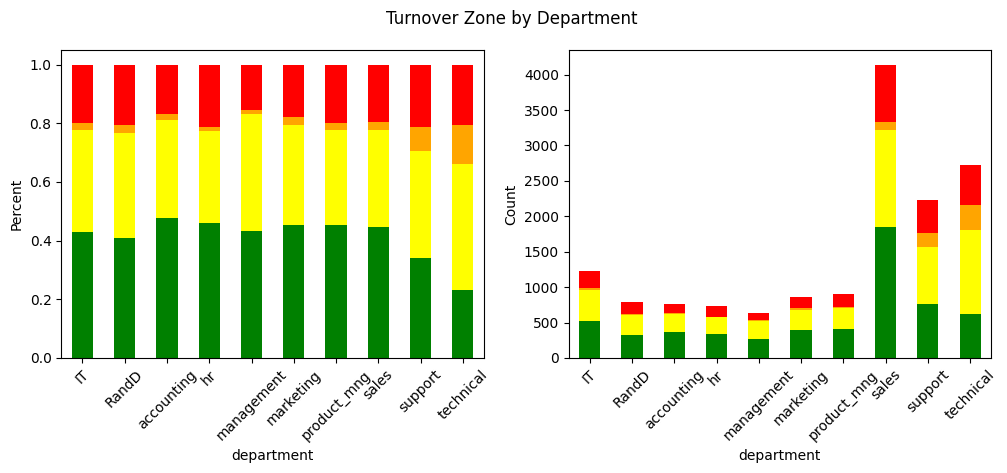

In [56]:
zone_cats_order = ["green", "yellow", "orange", "red"]
fig, axes = plt.subplots(ncols=2, nrows=1, figsize=(12, 4))

grouped_norm = (
    df.groupby("department")["turnover_probability_zone"]
    .value_counts(normalize=True)
    .unstack()
)
grouped_norm.columns = pd.CategoricalIndex(
    grouped_norm.columns.values, ordered=True, categories=zone_cats_order
)
grouped_norm = grouped_norm.sort_index(axis=1)
norm_plot = grouped_norm.plot(
    kind="bar", stacked=True, color=zone_cats_order, ax=axes[0], legend=False
)

group_count = (
    df.groupby("department")["turnover_probability_zone"].value_counts().unstack()
)
group_count.columns = pd.CategoricalIndex(
    group_count.columns.values, ordered=True, categories=zone_cats_order
)
group_count = group_count.sort_index(axis=1)
count_plot = group_count.plot(
    kind="bar", stacked=True, color=zone_cats_order, ax=axes[1], legend=False
)

fig.suptitle("Turnover Zone by Department")
norm_plot.set_ylabel("Percent")
norm_plot.xaxis.set_tick_params(labelrotation=45)
count_plot.set_ylabel("Count")
count_plot.xaxis.set_tick_params(labelrotation=45)

By department, Sales, Support, and Technical have the highest number of Red zone employees. However, as a percentage of employees within that department, other departments (e.g. HR, RandD, IT, and Product Management) have similarly high ratios of Red zone employees. Management and Accounting have the lowest percentage of Red zone employees.

Support and Technical have the highest percentage of Orange zone employees. Support, Technical, and Management have the highest percentage of Yellow zone employees.


### Green


In [57]:
green_zone = df[df["turnover_probability_zone"] == "green"]

Text(0, 0.5, 'Percent Salary Range')

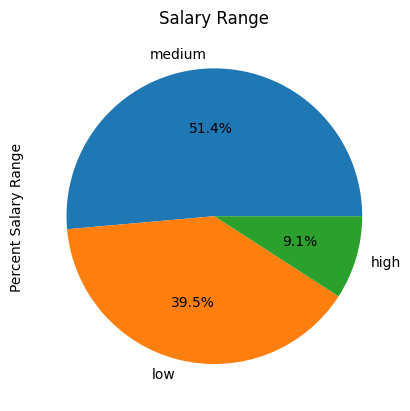

In [58]:
green_zone["salary"].value_counts(normalize=True).plot.pie(autopct="%1.1f%%")
plt.title("Salary Range")
plt.ylabel("Percent Salary Range")

Within the Green zone, the share of employees in the medium salary range is nearly 10% higher than the dataset on the whole (and 1% higher within the high range).


Text(0, 0.5, 'Department')

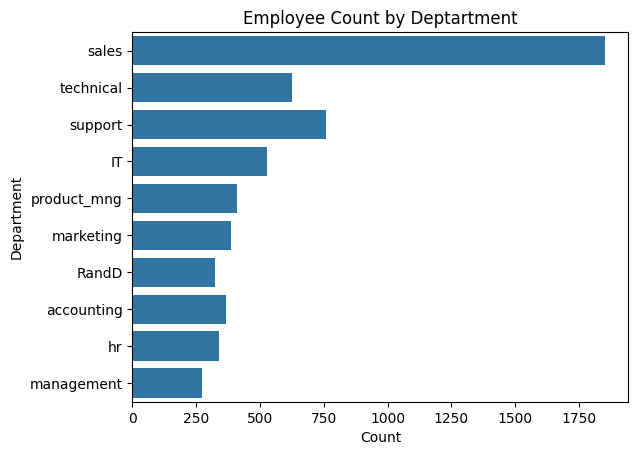

In [59]:
sns.countplot(
    green_zone,
    y="department",
    order=df["department"].value_counts().index,
)
plt.title("Employee Count by Deptartment")
plt.xlabel("Count")
plt.ylabel("Department")

Much like the dataset on the whole, Sales makes up the largest department by employee count in the Green zone. However, even as Technical and Support are the next highest by count, they each make up a smaller share amongst departments than within the dataset as a whole. This suggests that Sales is a relatively "safe" department from turnover, while Technical and Support may be at higher risk.


In [83]:
print(f"// satisfaction level (whole dataset): {df['satisfaction_level'].median()}")
print(
    f"// satisfaction level (green zone): {green_zone['satisfaction_level'].median()}"
)

print(f"// avg monthly hours (whole dataset): {df['average_montly_hours'].mean()}")
print(
    f"// avg monthly hours (green zone): {green_zone['average_montly_hours'].mean()}"
)

print(f"// num projects (whole dataset): {df['number_project'].mean()}")
print(f"// num projects (green zone): {green_zone['number_project'].mean()}")

print(
    f"// promotion in last 5 years (whole dataset): {df['promotion_last_5years'].mean()}"
)
print(
    f"// promotion in last 5 years (green zone): {green_zone['promotion_last_5years'].mean()}"
)

print(
    f"// last evaluation (whole dataset): {df['last_evaluation'].mean()}"
)
print(
    f"// last evaluation (green zone): {green_zone['last_evaluation'].mean()}"
)

// satisfaction level (whole dataset): 0.64
// satisfaction level (green zone): 0.43
// avg monthly hours (whole dataset): 201.0503366891126
// avg monthly hours (green zone): 193.7907214736483
// num projects (whole dataset): 3.80305353690246
// num projects (green zone): 3.5802490192734093
// promotion in last 5 years (whole dataset): 0.021268084538969265
// promotion in last 5 years (green zone): 0.022855193586900906
// last evaluation (whole dataset): 0.7161017401160078
// last evaluation (green zone): 0.6475592699982944


([0, 1, 2, 3, 4, 5, 6, 7, 8, 9],
 [Text(0, 0, 'IT'),
  Text(1, 0, 'RandD'),
  Text(2, 0, 'accounting'),
  Text(3, 0, 'hr'),
  Text(4, 0, 'management'),
  Text(5, 0, 'marketing'),
  Text(6, 0, 'product_mng'),
  Text(7, 0, 'sales'),
  Text(8, 0, 'support'),
  Text(9, 0, 'technical')])

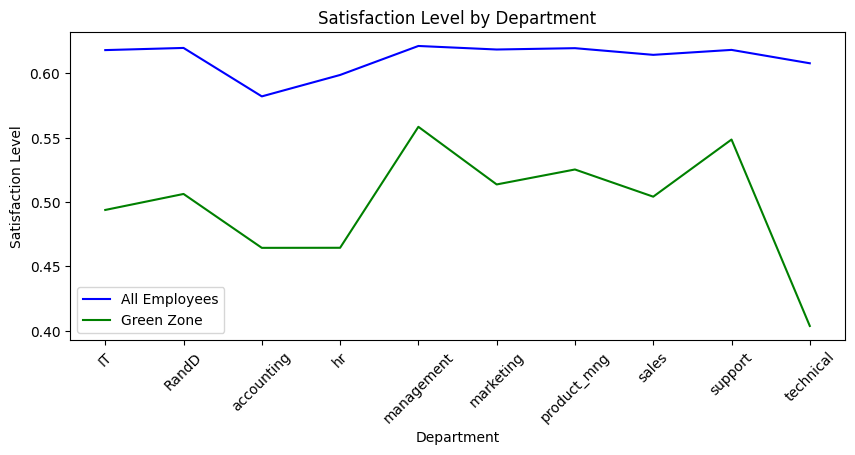

In [69]:
plt.figure(figsize=(10, 4))
sns.lineplot(
    df.groupby("department")["satisfaction_level"].mean(),
    legend="brief",
    label="All Employees",
    color="blue",
)
sns.lineplot(
    green_zone.groupby("department")["satisfaction_level"].mean(),
    legend="brief",
    label="Green Zone",
    color="green",
)
plt.title("Satisfaction Level by Department")
plt.xlabel("Department")
plt.ylabel("Satisfaction Level")
plt.xticks(rotation=45)

Employees in the Technical department are the least satisfied amongst departments in the Green zone.

Working on fewer projects, fewer hours, and receiving higher wages seem to be the best indicators for low risk of turnover, despite having a lower satisfaction level on average.

### Yellow


In [62]:
yellow_zone = df[df["turnover_probability_zone"] == "yellow"]

Text(0, 0.5, 'Percent Salary Range')

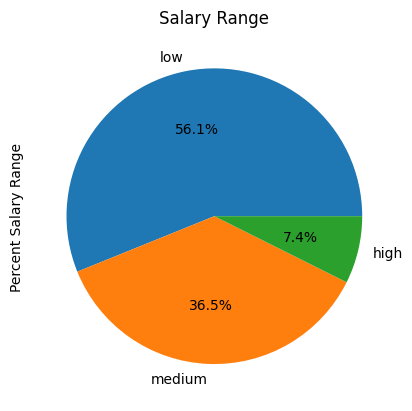

In [63]:
yellow_zone["salary"].value_counts(normalize=True).plot.pie(autopct="%1.1f%%")
plt.title("Salary Range")
plt.ylabel("Percent Salary Range")

Employees in the Yellow zone have slightly lower proportion of employees in the medium and high salary ranges than the dataset on the whole.


Text(0, 0.5, 'Department')

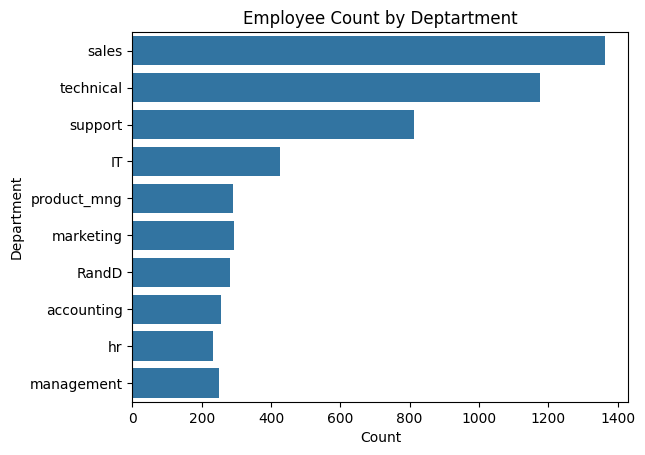

In [64]:
sns.countplot(
    yellow_zone,
    y="department",
    order=df["department"].value_counts().index,
)
plt.title("Employee Count by Deptartment")
plt.xlabel("Count")
plt.ylabel("Department")

In Technical and Support there are more employees in the Yellow zone than the Green zone. Sales remains the highest count in this zone as well.


In [81]:
print(f"// satisfaction level (whole dataset): {df['satisfaction_level'].median()}")
print(
    f"// satisfaction level (yellow zone): {yellow_zone['satisfaction_level'].median()}"
)

print(f"// avg monthly hours (whole dataset): {df['average_montly_hours'].mean()}")
print(
    f"// avg monthly hours (yellow zone): {yellow_zone['average_montly_hours'].mean()}"
)

print(f"// num projects (whole dataset): {df['number_project'].mean()}")
print(f"// num projects (yellow zone): {yellow_zone['number_project'].mean()}")

print(
    f"// promotion in last 5 years (whole dataset): {df['promotion_last_5years'].mean()}"
)
print(
    f"// promotion in last 5 years (yellow zone): {yellow_zone['promotion_last_5years'].mean()}"
)

print(
    f"// last evaluation (whole dataset): {df['last_evaluation'].mean()}"
)
print(
    f"// last evaluation (yellow zone): {yellow_zone['last_evaluation'].mean()}"
)

// satisfaction level (whole dataset): 0.64
// satisfaction level (yellow zone): 0.72
// avg monthly hours (whole dataset): 201.0503366891126
// avg monthly hours (yellow zone): 209.10830391974736
// num projects (whole dataset): 3.80305353690246
// num projects (yellow zone): 4.070406836336615
// promotion in last 5 years (whole dataset): 0.021268084538969265
// promotion in last 5 years (yellow zone): 0.023778562140070594
// last evaluation (whole dataset): 0.7161017401160078
// last evaluation (yellow zone): 0.7820564740850827


([0, 1, 2, 3, 4, 5, 6, 7, 8, 9],
 [Text(0, 0, 'IT'),
  Text(1, 0, 'RandD'),
  Text(2, 0, 'accounting'),
  Text(3, 0, 'hr'),
  Text(4, 0, 'management'),
  Text(5, 0, 'marketing'),
  Text(6, 0, 'product_mng'),
  Text(7, 0, 'sales'),
  Text(8, 0, 'support'),
  Text(9, 0, 'technical')])

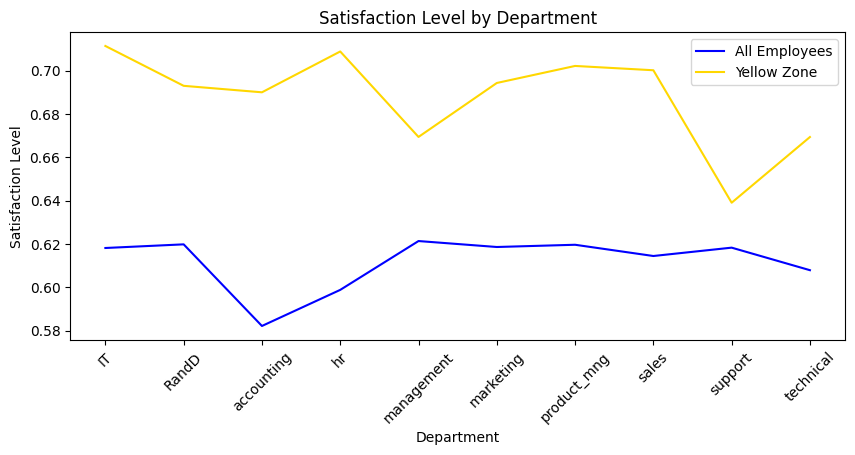

In [68]:
plt.figure(figsize=(10, 4))
sns.lineplot(
    df.groupby("department")["satisfaction_level"].mean(),
    legend="brief",
    label="All Employees",
    color="blue",
)
sns.lineplot(
    yellow_zone.groupby("department")["satisfaction_level"].mean(),
    legend="brief",
    label="Yellow Zone",
    color="gold",
)
plt.title("Satisfaction Level by Department")
plt.xlabel("Department")
plt.ylabel("Satisfaction Level")
plt.xticks(rotation=45)

Employee satisfaction level is higher amongst Yellow zone employees than average. Employees in this group scored higher on average in their last evaluation than the dataset average. However, employees work about 8 hours a month more on average and work on a slightly higher average number of projects than when looking at the dataset on the whole.

Support and Management have the lowest employee satisfaction among Yellow zone departments, unlike the dataset on the whole where these departments have the highest employee satisfaction.

### Orange


In [70]:
orange_zone = df[df["turnover_probability_zone"] == "orange"]

Text(0, 0.5, 'Percent Salary Range')

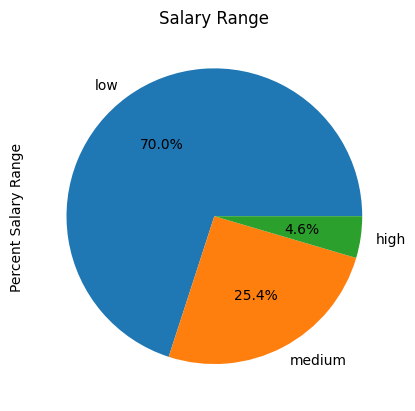

In [71]:
orange_zone["salary"].value_counts(normalize=True).plot.pie(autopct="%1.1f%%")
plt.title("Salary Range")
plt.ylabel("Percent Salary Range")

There is a much higher percentage of employees within the Low salary range than for the dataset on the whole. This appears to be a key indicator for employees at high risk for turnover, especially within the Technical and Support departments.

Text(0, 0.5, 'Department')

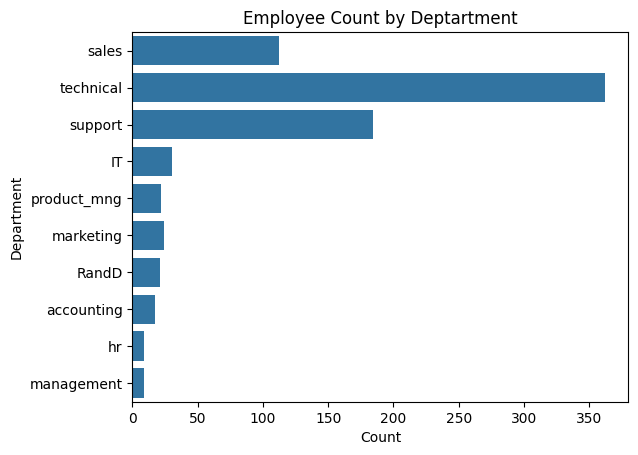

In [72]:
sns.countplot(
    orange_zone,
    y="department",
    order=df["department"].value_counts().index,
)
plt.title("Employee Count by Deptartment")
plt.xlabel("Count")
plt.ylabel("Department")

Most employees in the Orange zone are in Technical or Support departments.

([0, 1, 2, 3, 4, 5, 6, 7, 8, 9],
 [Text(0, 0, 'IT'),
  Text(1, 0, 'RandD'),
  Text(2, 0, 'accounting'),
  Text(3, 0, 'hr'),
  Text(4, 0, 'management'),
  Text(5, 0, 'marketing'),
  Text(6, 0, 'product_mng'),
  Text(7, 0, 'sales'),
  Text(8, 0, 'support'),
  Text(9, 0, 'technical')])

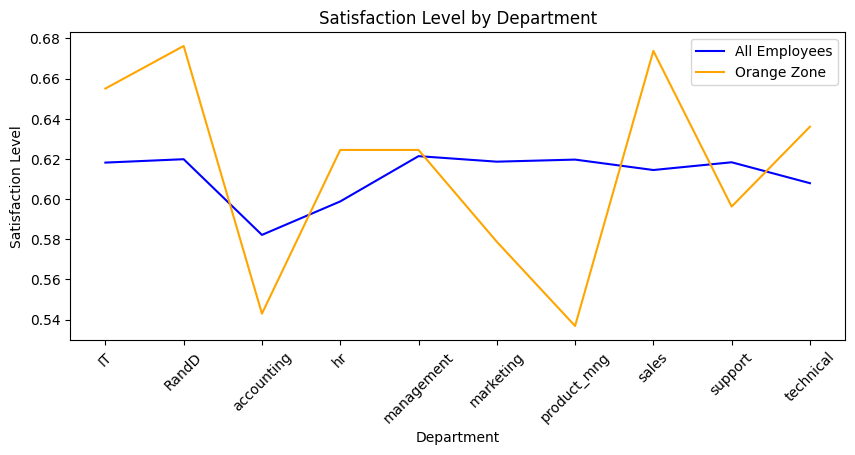

In [87]:
plt.figure(figsize=(10, 4))
sns.lineplot(
    df.groupby("department")["satisfaction_level"].mean(),
    legend="brief",
    label="All Employees",
    color="blue",
)
sns.lineplot(
    orange_zone.groupby("department")["satisfaction_level"].mean(),
    legend="brief",
    label="Orange Zone",
    color="orange",
)
plt.title("Satisfaction Level by Department")
plt.xlabel("Department")
plt.ylabel("Satisfaction Level")
plt.xticks(rotation=45)

In [84]:
print(f"// satisfaction level (whole dataset): {df['satisfaction_level'].median()}")
print(
    f"// satisfaction level (orange zone): {orange_zone['satisfaction_level'].median()}"
)

print(f"// avg monthly hours (whole dataset): {df['average_montly_hours'].mean()}")
print(
    f"// avg monthly hours (orange zone): {orange_zone['average_montly_hours'].mean()}"
)

print(f"// num projects (whole dataset): {df['number_project'].mean()}")
print(f"// num projects (orange zone): {orange_zone['number_project'].mean()}")

print(
    f"// promotion in last 5 years (whole dataset): {df['promotion_last_5years'].mean()}"
)
print(
    f"// promotion in last 5 years (orange zone): {orange_zone['promotion_last_5years'].mean()}"
)

print(f"// last evaluation (whole dataset): {df['last_evaluation'].mean()}")
print(f"// last evaluation (orange zone): {orange_zone['last_evaluation'].mean()}")

// satisfaction level (whole dataset): 0.64
// satisfaction level (orange zone): 0.66
// avg monthly hours (whole dataset): 201.0503366891126
// avg monthly hours (orange zone): 198.36075949367088
// num projects (whole dataset): 3.80305353690246
// num projects (orange zone): 3.713924050632911
// promotion in last 5 years (whole dataset): 0.021268084538969265
// promotion in last 5 years (orange zone): 0.012658227848101266
// last evaluation (whole dataset): 0.7161017401160078
// last evaluation (orange zone): 0.7202911392405063


In many respects, the Orange zone reflects the dataset on the whole, with similar average satisfaction levels, monthly hours and projects, and score of last evaluation. However, this group received promotions at half the rate of the dataset on the whole and percentage of medium and high salaried employees is well below the average.

The majority of Orange zone employees are within the Technical and Support departments. The Orange zone has the most variation for employee satisfaction level between departments, with low satisfaction in Accounting and Product Management (relative the whole dataset). In fact, this zone appears to be bringing down the average for the dataset on the whole. This suggests that department-specific dissatisfaction may be a high risk factor for turnover.

### Red


In [88]:
red_zone = df[df["turnover_probability_zone"] == "red"]

Text(0, 0.5, 'Percent Salary Range')

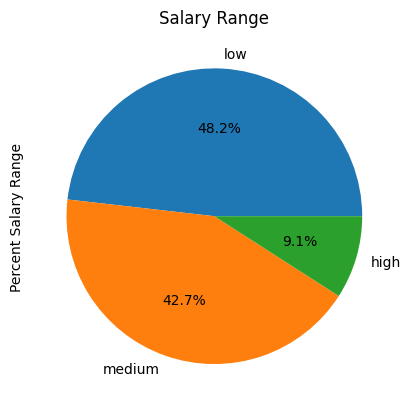

In [89]:
red_zone["salary"].value_counts(normalize=True).plot.pie(autopct="%1.1f%%")
plt.title("Salary Range")
plt.ylabel("Percent Salary Range")

The makeup of salary ranges in the Red zone is very similar to the dataset on the whole.

Text(0, 0.5, 'Department')

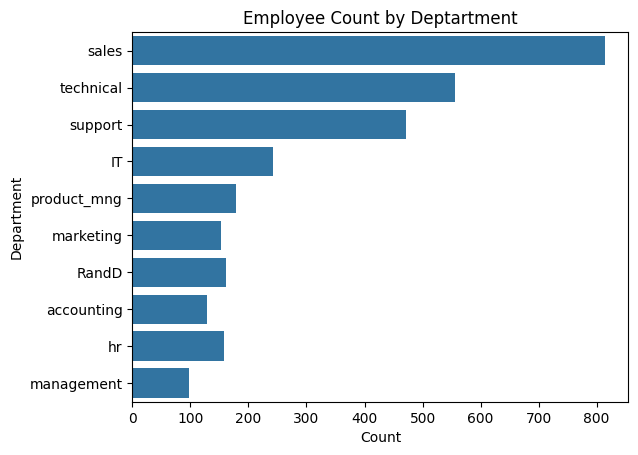

In [90]:
sns.countplot(
    red_zone,
    y="department",
    order=df["department"].value_counts().index,
)
plt.title("Employee Count by Deptartment")
plt.xlabel("Count")
plt.ylabel("Department")

While Sales, Technical, and Support make up the largest number of employees by count, IT and HR have a high count for this zone compared to the dataset on the whole.

([0, 1, 2, 3, 4, 5, 6, 7, 8, 9],
 [Text(0, 0, 'IT'),
  Text(1, 0, 'RandD'),
  Text(2, 0, 'accounting'),
  Text(3, 0, 'hr'),
  Text(4, 0, 'management'),
  Text(5, 0, 'marketing'),
  Text(6, 0, 'product_mng'),
  Text(7, 0, 'sales'),
  Text(8, 0, 'support'),
  Text(9, 0, 'technical')])

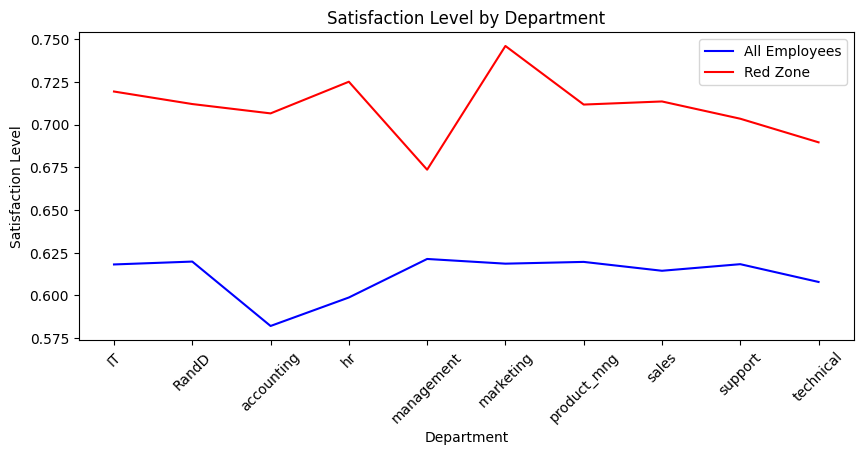

In [91]:
plt.figure(figsize=(10, 4))
sns.lineplot(
    df.groupby("department")["satisfaction_level"].mean(),
    legend="brief",
    label="All Employees",
    color="blue",
)
sns.lineplot(
    red_zone.groupby("department")["satisfaction_level"].mean(),
    legend="brief",
    label="Red Zone",
    color="red",
)
plt.title("Satisfaction Level by Department")
plt.xlabel("Department")
plt.ylabel("Satisfaction Level")
plt.xticks(rotation=45)

In [92]:
print(f"// satisfaction level (whole dataset): {df['satisfaction_level'].median()}")
print(
    f"// satisfaction level (red zone): {red_zone['satisfaction_level'].median()}"
)

print(f"// avg monthly hours (whole dataset): {df['average_montly_hours'].mean()}")
print(
    f"// avg monthly hours (red zone): {red_zone['average_montly_hours'].mean()}"
)

print(f"// num projects (whole dataset): {df['number_project'].mean()}")
print(f"// num projects (red zone): {red_zone['number_project'].mean()}")

print(
    f"// promotion in last 5 years (whole dataset): {df['promotion_last_5years'].mean()}"
)
print(
    f"// promotion in last 5 years (red zone): {red_zone['promotion_last_5years'].mean()}"
)

print(f"// last evaluation (whole dataset): {df['last_evaluation'].mean()}")
print(f"// last evaluation (red zone): {red_zone['last_evaluation'].mean()}")

// satisfaction level (whole dataset): 0.64
// satisfaction level (red zone): 0.71
// avg monthly hours (whole dataset): 201.0503366891126
// avg monthly hours (red zone): 201.4930813364833
// num projects (whole dataset): 3.80305353690246
// num projects (red zone): 3.781977725278434
// promotion in last 5 years (whole dataset): 0.021268084538969265
// promotion in last 5 years (red zone): 0.015862301721228485
// last evaluation (whole dataset): 0.7161017401160078
// last evaluation (red zone): 0.7307897401282484


Red zone employees received slightly higher scores than the average during their last evaluation but are receiving promotions at lower rates than average. Oddly, employees in this zone are reporting slightly higher employee satisfaction rates in every department than the average.

## Key Takeaways

- High-performing employees are not receiving regular promotions and promotions in general are happening at very low rates amongst all departments
- High-performing employees are working more hours and on more projects than average but are receiving promotions at much lower rates
- The largest percentage of high salaried employees are within Management, while the departments with the most employees (like Sales, Technical, and Support) have a disproportionately low percentage of medium and high salaried employees compared to other departments
- Dissatisfaction within Accounting and Product Management is a high risk factor for turnover
- A disproportionately high percentage of low salaried employees and a disproportionately low percentage of promotions within the Technical and Support departments (which make up a large percentage of all employees) are also key indicators of high turnover